# ARMA, ARIMA, SARIMA

## Overview

- In the previous four lessons, we learned about stationarity, smoothing, trend, seasonality, and autocorrelation, and you built two different kinds of models:

> **MA models**: The current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.

> **AR models**: The current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).
  
- In this lesson we will review these concepts and combine the AR and MA models into three more complicated ones: ARMA, ARIMA, and SARIMA.

In particular, we will cover:

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

In [33]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error as mse
np.random.seed(0)

---

## ARMA

The ARMA model (also known as the *Box-Jenkins* approach) combines two models:

- An autoregressive (AR) model of order $p$.
- A moving average (MA) model of order $q$.

### Load data

- In the following, we'll look at the monthly average temperatures between 1907-1972.

In [3]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1',
                           skipfooter=2,
                           header=0,
                           index_col=0,
                           names=['month', 'temp'],
                           engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [4]:
monthly_temp.head()

temp
month           
1907-01-01  33.3
1907-02-01  46.0
1907-03-01  43.0
1907-04-01  55.0
1907-05-01  51.8

In [5]:
monthly_temp.describe()

temp
count  792.000000
mean    53.553662
std     15.815452
min     11.200000
25%     39.675000
50%     52.150000
75%     67.200000
max     82.400000

- This is the run sequence plot.

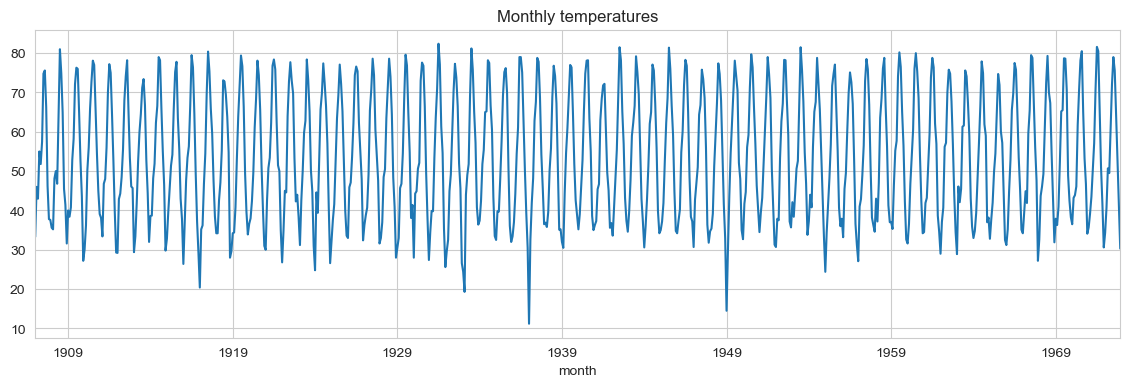

In [6]:
monthly_temp['temp'].plot(grid=True, figsize=(14, 4), title="Monthly temperatures");

- Compute the annual mean and plot it on top of the actual data.

/var/folders/5l/bpjqgv5n3j3c9_70lx8t43400000gn/T/ipykernel_60792/3907938318.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_temp = monthly_temp.resample('A').mean()


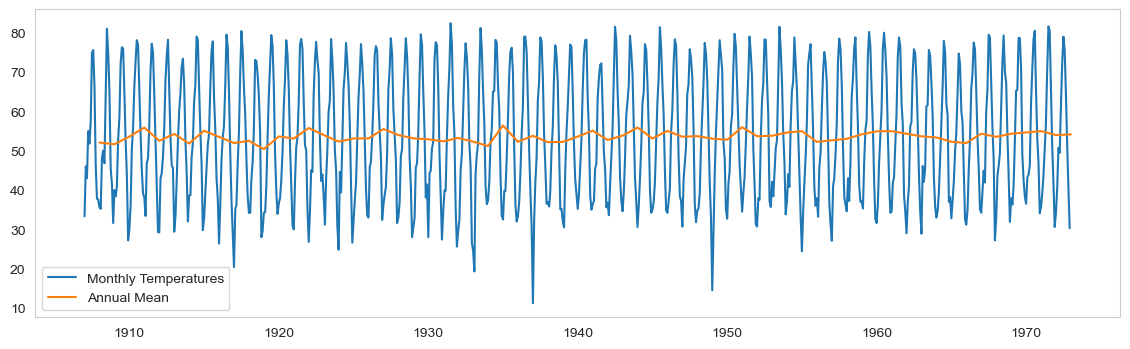

In [7]:
# Compute annual mean
annual_temp = monthly_temp.resample('A').mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(14, 4))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- This gives us an indication that the mean is rather constant over the years.
- We can extract further information abouth the underlying trend and seasonality by performing a seasonal decomposition.
- We can use both the `seasonal_decompose` and the `STL` methods.

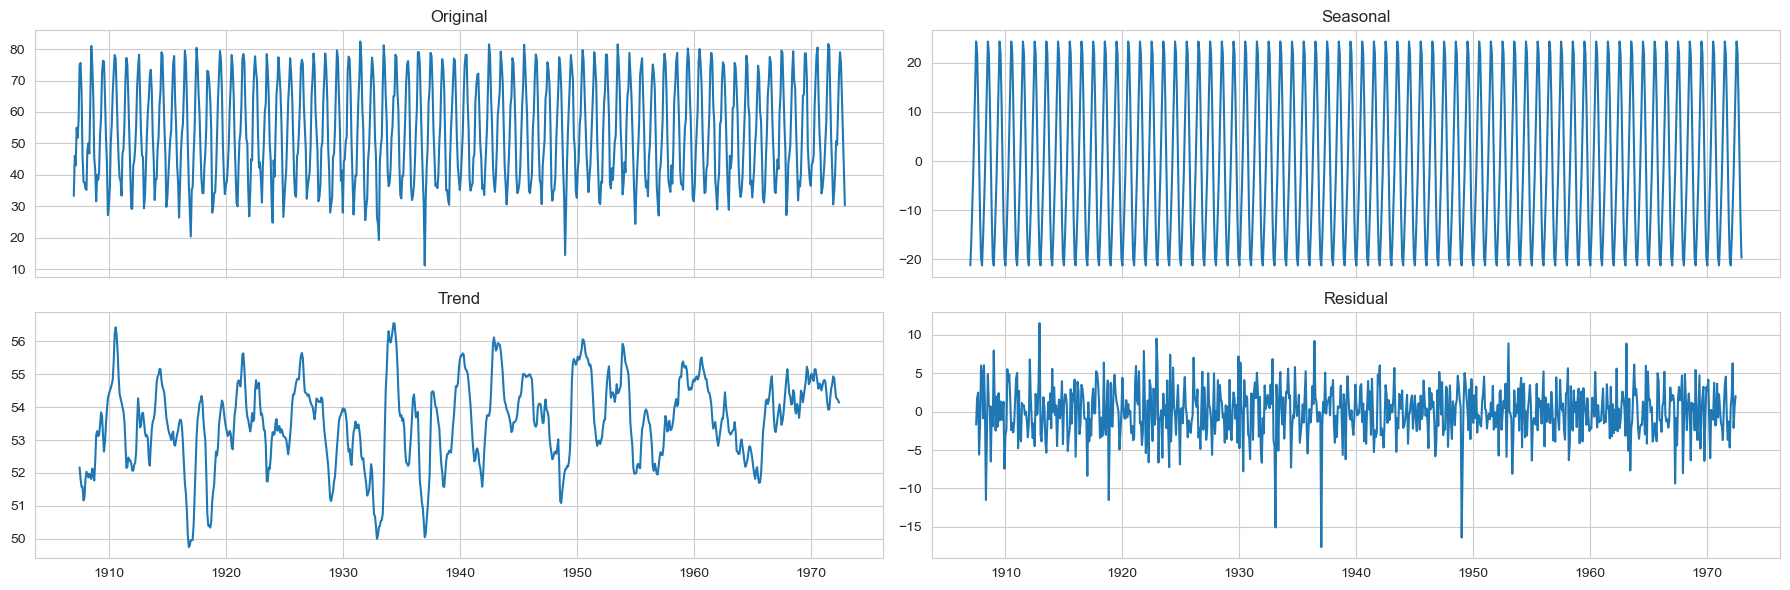

In [8]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

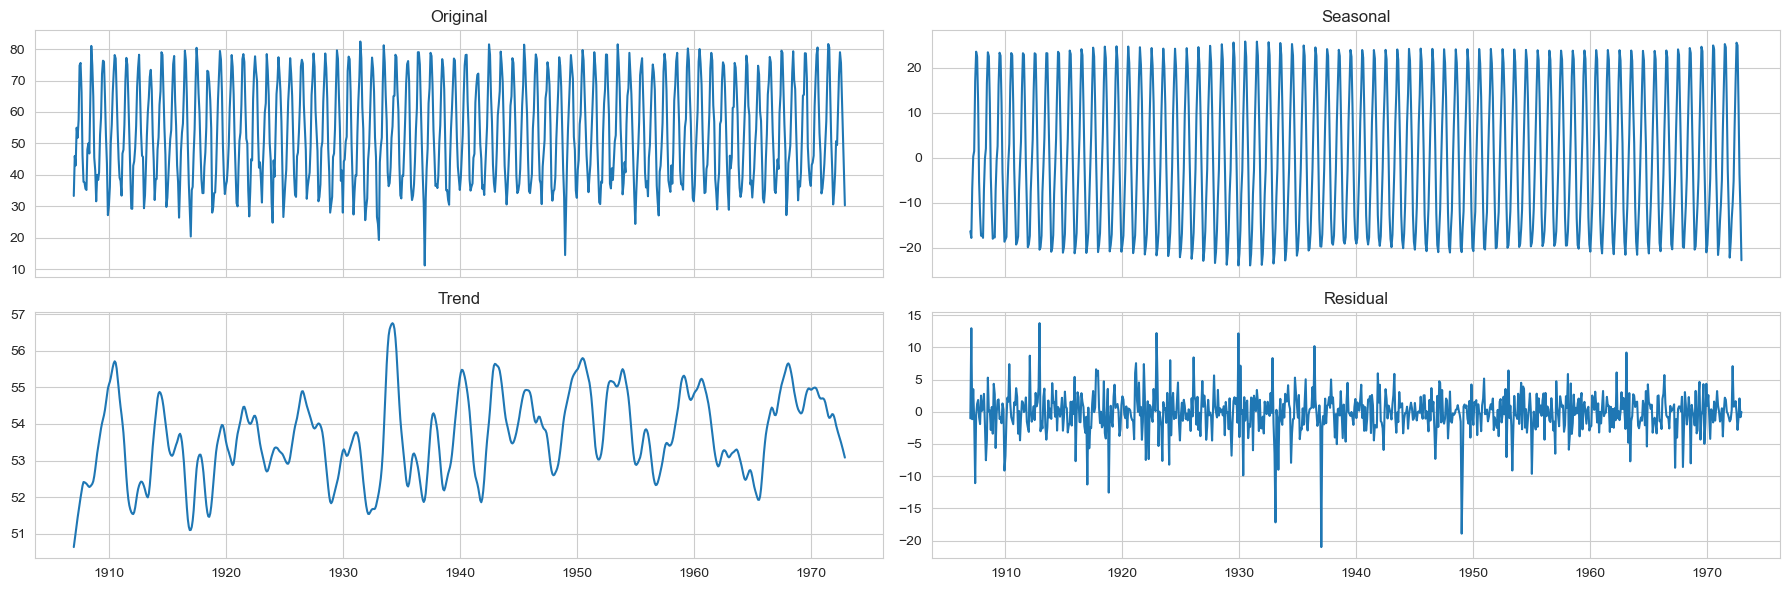

In [9]:
decomposition = STL(endog=monthly_temp['temp'], period=12, seasonal=13, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

## ARMA modeling stages

### Model identification

- Model identification consists in finding the orders $p$ and $q$ AR and MA components.
- Before performing model identification we need to:
    1. Determine if the time series is stationary.
    2. Determine if the time series has seasonal component.

#### Determine stationarity

- We will use tools we already know (ADF test).

In [10]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid()

ADF Statistic: -6.48
p-value: 0.000
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



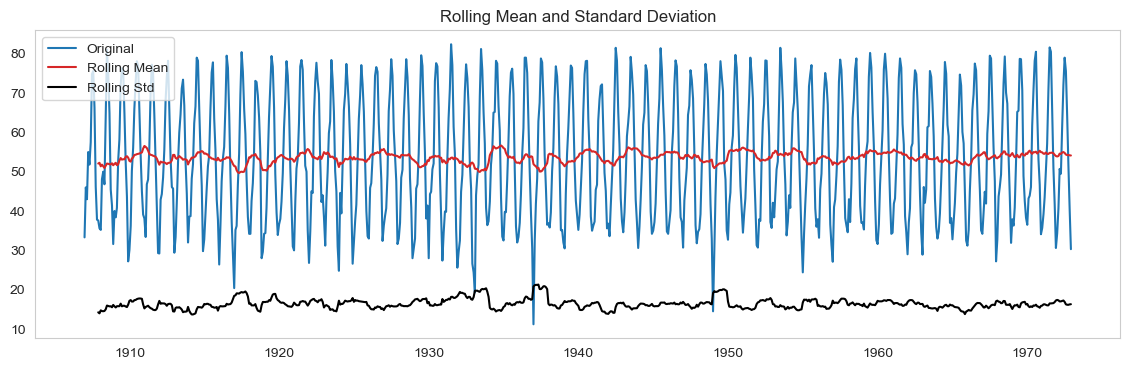

In [11]:
# run ADF on monthly temperatures
adftest(monthly_temp.temp)

- The p-value indicates that the time series is stationary...
- ... even if it clearly has a periodic component.
- The rolling mean and rolling standard deviation seem globally constant along the time series...
- ... even if they change locally within the period.

#### Determine seasonality

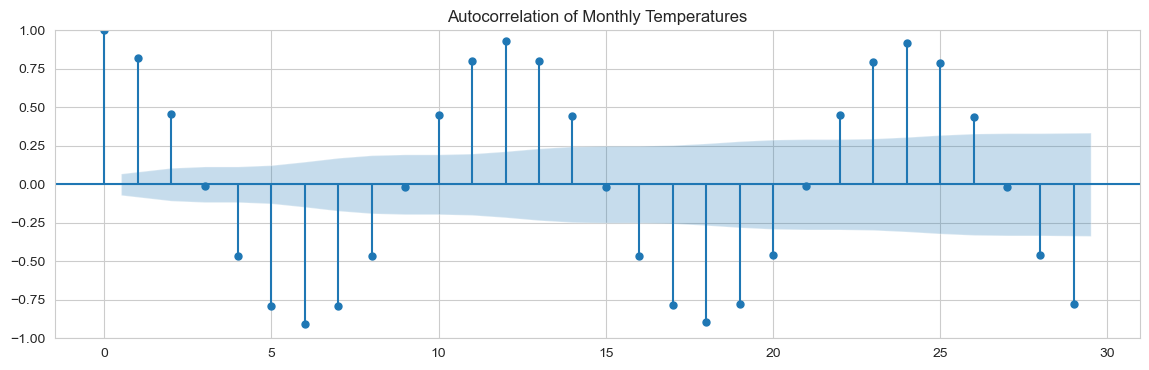

In [12]:
# Plotting ACF for the 'temp' column
fig, ax = plt.subplots(figsize=(14, 4))
plot_acf(monthly_temp['temp'], ax=ax, title="Autocorrelation of Monthly Temperatures")
plt.grid(True)
plt.show()

#### Remove the main seasonality

- In this case, it is clear that the main seasonality is $L=12$.
- We can remove it with a seasonal differencing.

In [14]:
monthly_temp['Seasonally_Differenced'] = monthly_temp['temp'].diff(12)

In [15]:
# Drop nan
monthly_temp_clean = monthly_temp.dropna()
monthly_temp_clean

temp  Seasonally_Differenced
month                                   
1908-01-01  35.6                     2.3
1908-02-01  35.2                   -10.8
1908-03-01  48.1                     5.1
1908-04-01  50.0                    -5.0
1908-05-01  46.8                    -5.0
...          ...                     ...
1972-08-01  75.6                    -4.9
1972-09-01  64.1                    -1.7
1972-10-01  51.7                     0.6
1972-11-01  40.3                    -1.5
1972-12-01  30.3                    -0.3

[780 rows x 2 columns]

#### Identifying $p$ and $q$

As we learned in the previous lesson, we will identify the AR order $p$ and the MA order $q$ with:

- Autocorrelation function (ACF) plot.
- Partial autocorrelation function (PACF) plot.

**AR($p$)**

- The order of the AR model is identified as follows:
    - Plot 95% confidence interval on the PACF (done automatically by statsmodels).
    - Choose lag $p$ such that the partial autocorrelation becomes insignificant for $p+1$ and beyond.

- If a process depends on previous values of itself then it is an AR process.
- If it depends on previous errors than it is an MA process.
- An AR process propagates shocks infinitely.
- AR processes will exhibit exponential decay in ACF and a cut-off in PACF.

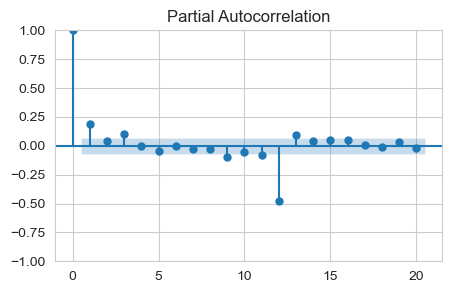

In [16]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- It looks like the PACF becomes zero at lag 2.
- However there is a non-zero partial autocorrelation at lag 3.
- The optimal value might be $p=1$, $p=2$, or $p=3$.
- Note that there are high partial autocorrelations at higher lags, especially 12.
    - This is an effect from seasonality and seasonal differencing.
    - It should not be accounted when chosing $p$.

**MA($q$)**

- The order of the MA model is identified as follows:
    - Plot 95% confidence interval on the ACF (done automatically by statsmodels).
    - Choose lag $q$ such that ACF becomes statistically zero for $q+1$ and beyond.

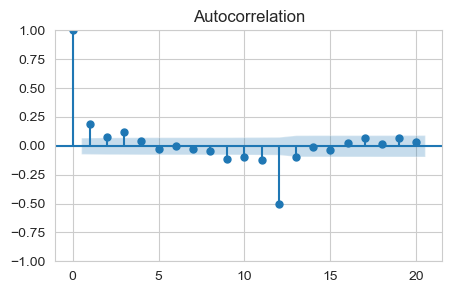

In [17]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

- Also in this case there are non-zero autocorrelations at lags 1 and 3.
- So, the values to try are $q=1$, $q=2$, or $q=3$.

- We split the data in two parts:
    - the training set, that will be used to fit the model's parameters.
    - the test set, that will be used later on to evaluate the prediction performance of the model on unseen data.

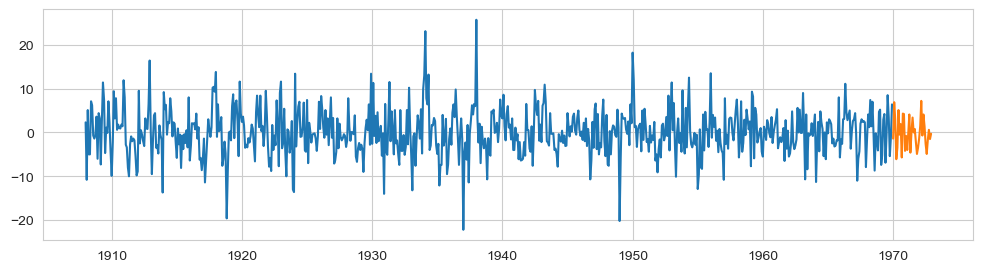

In [18]:
train = monthly_temp_clean['Seasonally_Differenced'][:-36]
test = monthly_temp_clean['Seasonally_Differenced'][-36:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [19]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

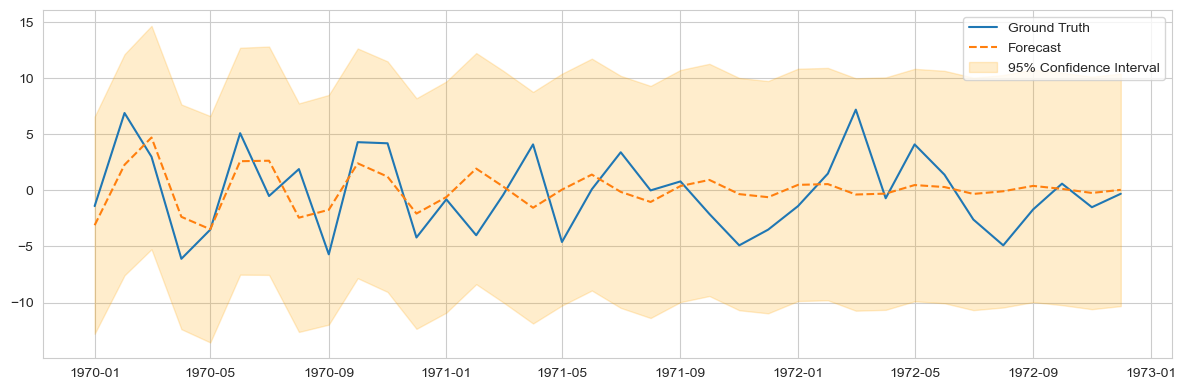

In [20]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Ground Truth')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.tight_layout()

In [34]:
# Assuming test and pred_summary['mean'] are numpy arrays or pandas series
ground_truth = test.values  # Converting test to numpy array for MSE calculation
predictions = pred_summary['mean'].values  # Predictions from the model

# Calculating Mean Squared Error (MSE)
mse_arma = mse(ground_truth, predictions)
print(f"MSE of differencing: {mse_arma:.2f}")

MSE of differencing: 10.09


---

## ARIMA Model

- ARIMA stands for Auto Regressive Integrated Moving Average.
- ARIMA models have three components:
    - AR model.
    - Integrated component (more on this shortly).
    - MA model.

- The ARIMA model is denoted ARIMA($p, d, q$).
    - $p$ is the order of the AR model.
    - $d$ is the number of times to **difference the data (trend differencing)**.
    - $q$ is the order of the MA model.
    - $p$, $d$, and $q$ are nonnegative integers.

- The **ARMA model is suitable for stationary time series** where the mean and variance do not change over time.
- The **ARIMA model effectively models non-stationary time series** by differencing the data.
- In practice, ARIMA makes the time series stationary before applying the ARMA model.
- Let's see it with an example.

In [22]:
# Generate synthetic stationary data with an ARMA(1,1) process
n = 250
ar_coeff = np.array([1, -0.7]) # The first value refers to lag 0 and is always 1. In addition, AR coeff are negated.
ma_coeff = np.array([1, 0.7])  # The first value refers to lag 0 and is always 1

# stationary data
arma_data = ss.tsa.arima_process.ArmaProcess(ar_coeff, ma_coeff).generate_sample(nsample=n, burnin=1000)

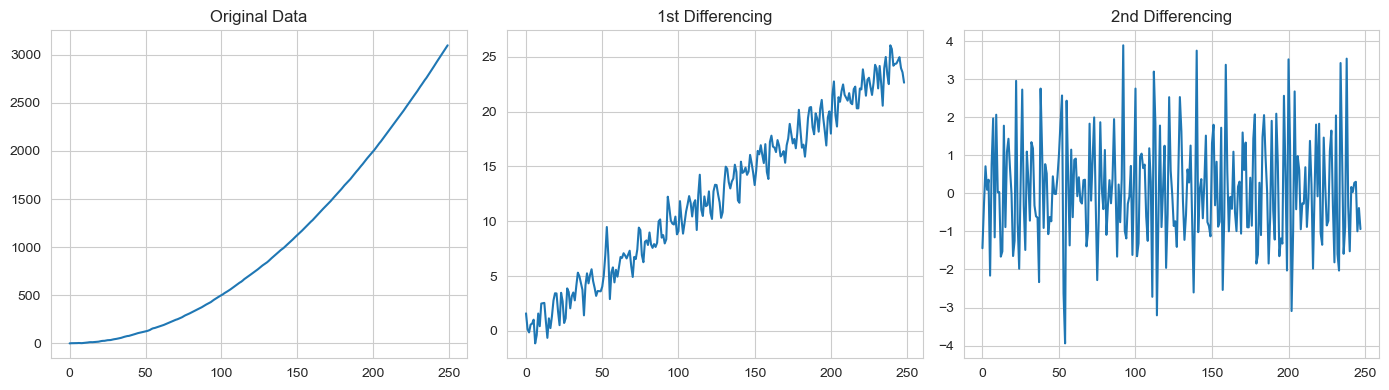

In [23]:
# Generate a synthetic non-stationary data (needs to be differenced twice to be stationary)
t = np.arange(n)
non_stationary_data = 0.05 * t**2 + arma_data  # Quadratic trend

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(non_stationary_data)
axes[0].set_title('Original Data')
axes[1].plot(diff(non_stationary_data, k_diff=1))
axes[1].set_title('1st Differencing')
axes[2].plot(diff(non_stationary_data, k_diff=2))
axes[2].set_title('2nd Differencing')
plt.tight_layout();

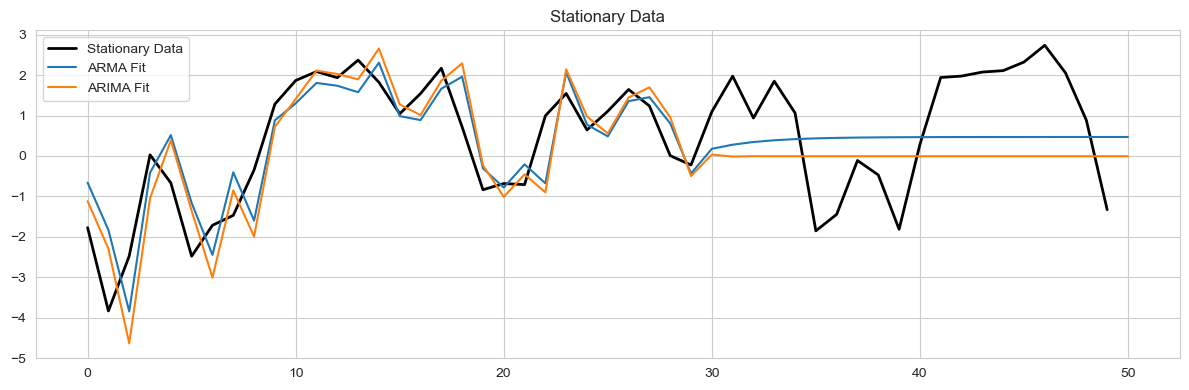

In [24]:
# Fit models to stationary data
arma_model = ARIMA(arma_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(arma_data[:-20], order=(1, 1, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(arma_data[-50:], 'k', label='Stationary Data', linewidth=2)
plt.plot(arma_model.predict(200,250), label='ARMA Fit')
plt.plot(arima_model.predict(200, 250), label='ARIMA Fit')
plt.legend()
plt.title('Stationary Data')
plt.tight_layout();


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


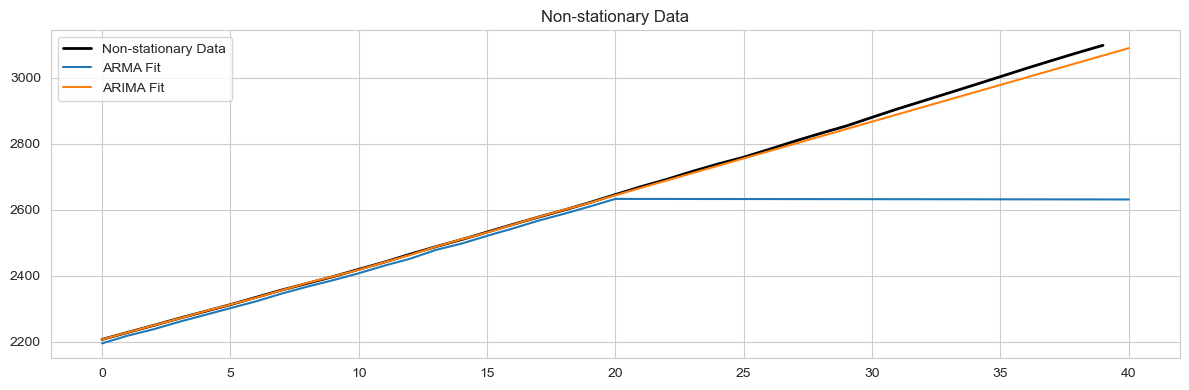

In [25]:
# Fit models to non-stationary data
arma_model = ARIMA(non_stationary_data[:-20], order=(1, 0, 1)).fit()
arima_model = ARIMA(non_stationary_data[:-20], order=(1, 2, 1)).fit()

plt.figure(figsize=(12, 4))
plt.plot(non_stationary_data[-40:], 'k', label='Non-stationary Data', linewidth=2)
plt.plot(arma_model.predict(210,250), label='ARMA Fit')
plt.plot(arima_model.predict(210,250), label='ARIMA Fit')
plt.legend()
plt.title('Non-stationary Data')
plt.tight_layout();

---

## SARIMA

- SARIMA is an extension of ARIMA that includes seasonal terms.
- The model is specified as SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Regular ARIMA components $(p, d, q)$.
  - Seasonal components $(P, D, Q, s)$ where:
    - $P$: Seasonal AR order.
    - $D$: Seasonal differencing order.
    - $Q$: Seasonal MA order.
    - $s$: Number of time steps for a single seasonal period.

**How to select the values $s, P, D, Q$?**
- $s$:Seasonality period (e.g., 12 for monthly data)
- $D$:You determine $D$ by applying seasonal differencing. If the **seasonal component becomes stationary after the first seasonal difference $D$=1**, Otherwise, further differencing might be needed.
- $P$:Look at the PACF plot of the seasonally differenced data. **Seasonal PACF spikes at lags that are multiples of the seasonality period** (e.g., 12 for monthly data) indicate the potential value of P
- $Q$:Look at the ACF plot of the seasonally differenced data. **Seasonal ACF spikes at lags that are multiples of the seasonality period** (e.g., 12 for monthly data) indicate the potential value of Q


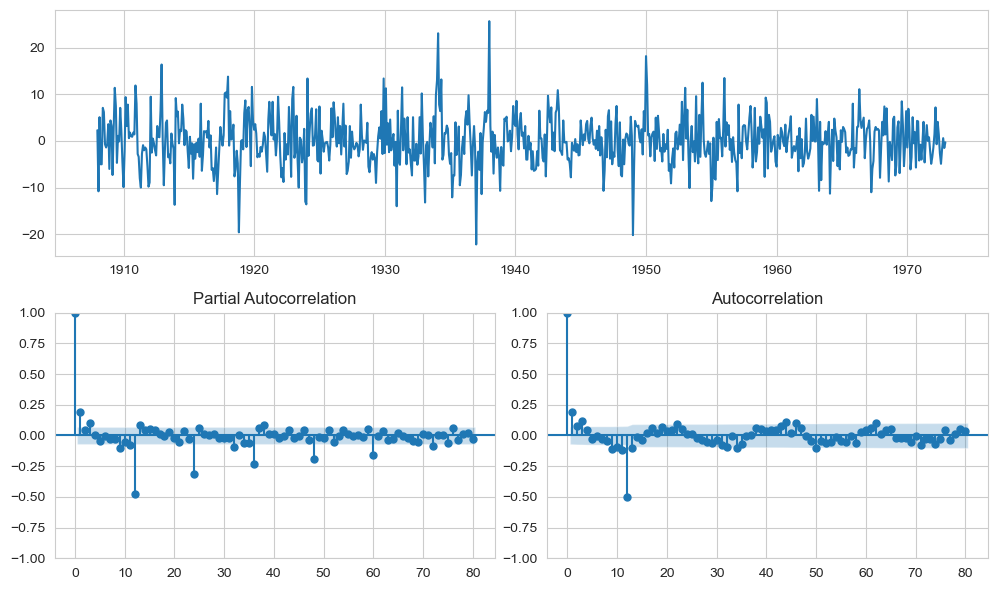

In [36]:
diff_ts = monthly_temp['temp'].diff(periods=12).dropna()

fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(diff_ts)

ax2 = plt.subplot2grid((2, 2), (1, 0))
plot_pacf(diff_ts, lags=80, ax=ax2)

ax3 = plt.subplot2grid((2, 2), (1, 1))
plot_acf(diff_ts, lags=80, ax=ax3)

plt.tight_layout();

In [27]:
# fit SARIMA monthly based on helper plots
sar = ss.tsa.statespace.sarimax.SARIMAX(monthly_temp[:750].temp,
                                order=(3,0,3), # (p,d,q)
                                seasonal_order=(1,1,1,12), # (P,D,Q,s)
                                trend='c').fit(disp=False)

MSE: 8.84


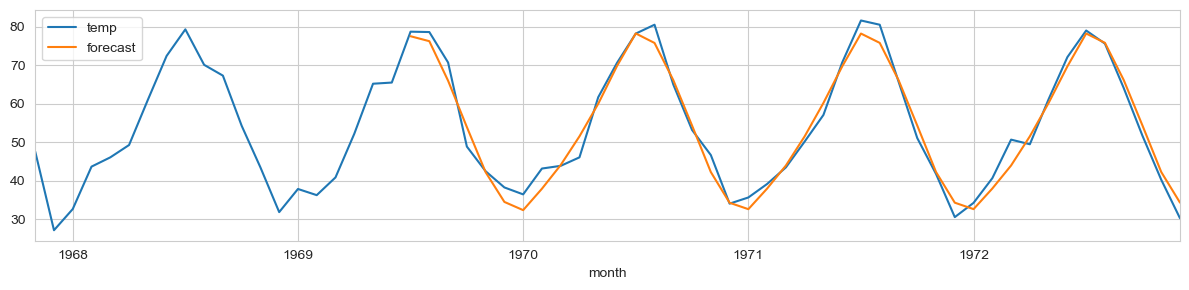

In [35]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 792, dynamic=False)
monthly_temp[730:][['temp', 'forecast']].plot(figsize=(12, 3))
plt.tight_layout()
print(f"MSE: {mse(monthly_temp['temp'][-42:], monthly_temp['forecast'][-42:]):.2f}")